In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

import numpy as np
import matplotlib.pyplot as plt
from numpy.fft import rfft,irfft
from matplotlib.colors import LogNorm
from itertools import combinations
import sys, os
import astropy.coordinates
import astropy.cosmology

parent_directory = os.path.dirname(os.getcwd())
sys.path.append(parent_directory)
import telescope_1d

In [2]:
# Initialize telescope
telescope = telescope_1d.Telescope1D(Nfreq=256, Ndishes=32, DDish=6, Npix_fft=2**12, Npad=2**8,
                                     minfreq=400, maxfreq=800, redundant=False)

Get beam sensitivity for baseline length 6 meters, frequency 800 MHz:

Text(0, 0.5, 'Power')

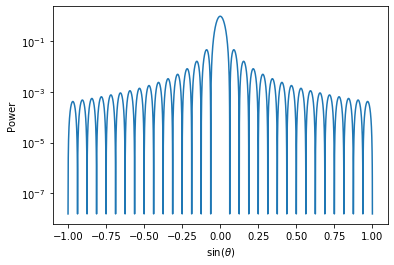

In [3]:
pbeam = telescope.primary_beam_1(800)**2 
plt.plot(telescope.alpha,pbeam/pbeam.max())
plt.semilogy()
plt.xlabel(r'sin($\theta$)')
plt.ylabel('Power')

Let's find a response to a point source.

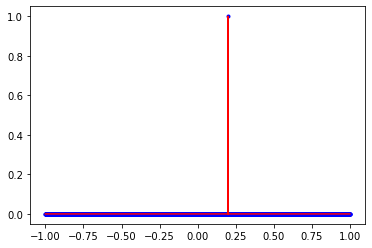

In [4]:
idx = int(telescope.Npix*60/100)
image = telescope.get_point_source_sky(idx=[idx])
plt.plot(telescope.alpha,image,'b.')
plt.plot(telescope.alpha,telescope.uv2image(telescope.image2uv(image)),'r-')

Ignore beam for now. Transform image to uv space, then pick out the indices we want and construct uvplane.

/usr/lib/python3/dist-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


Text(0, 0.5, 'visibility')

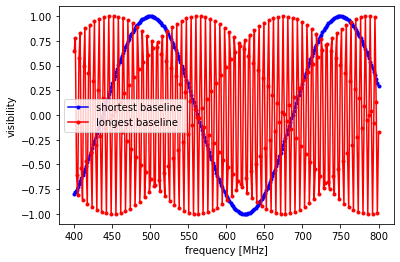

In [5]:
uv = telescope.image2uv(image)
uvplane = telescope.uv2uvplane(uv, indices=None)
plt.plot(telescope.freqs,uvplane[:,0],'b.-', label='shortest baseline')
plt.plot(telescope.freqs,uvplane[:,-1],'r.-', label='longest baseline')
plt.legend()
plt.xlabel('frequency [MHz]')
plt.ylabel('visibility')

Compare with visibility from analytical approach (for shortest baseline).

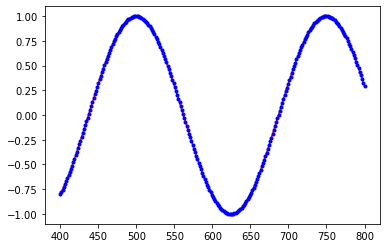

In [6]:
al = telescope.alpha[idx]
direct = np.cos(telescope.DDish/telescope.lams*2*np.pi*al)
plt.plot(telescope.freqs,direct,'r-')
plt.plot(telescope.freqs,uvplane[:,0],'b.')

We can now see the interpolation errors; the scheme is percent accurate.

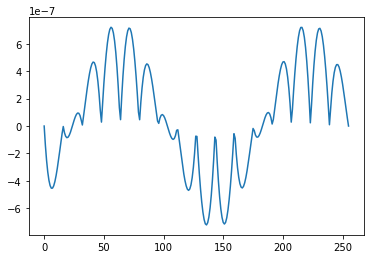

In [7]:
plt.plot(direct-np.real(uvplane[:,0]))

Let's image this back. Try with and without error (use time delay error of sigma 10 picoseconds).

In [8]:
rmap_no_error = telescope.get_obs_rmap(uvplane, time_error_sigma=0)
rmap_with_error = telescope.get_obs_rmap(uvplane, time_error_sigma=10e-12)

Plot the synthesized beams. Choose range of angles close to where the point source is.

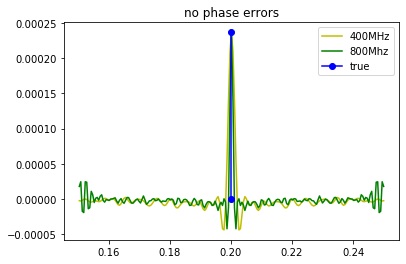

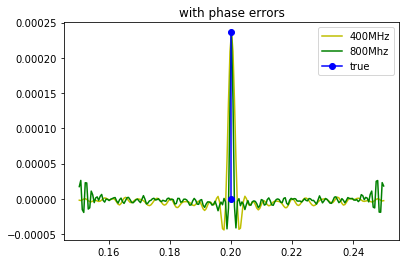

In [9]:
wal = np.where((telescope.alpha>al-0.05) & (telescope.alpha<al+0.05))

plt.plot(telescope.alpha[wal],rmap_no_error[0,wal[0]],'y-',label='400MHz')
plt.plot(telescope.alpha[wal],rmap_no_error[255,wal[0]],'g-',label='800Mhz')
plt.plot([al,al],[0,rmap_no_error.max()],'bo-',label='true')
plt.title('no phase errors')
plt.legend()
plt.show()

plt.plot(telescope.alpha[wal],rmap_with_error[0,wal[0]],'y-',label='400MHz')
plt.plot(telescope.alpha[wal],rmap_with_error[255,wal[0]],'g-',label='800Mhz')
plt.plot([al,al],[0,rmap_with_error.max()],'bo-',label='true')
plt.title('with phase errors')
plt.legend()
plt.show()

Plot the rmap for the two cases. The lines from redundant baselines are faded and more sparse with less redundant baseline lengths. With significantly large phase errors, the lines go away, because phase errors shift each line, and since phase errors are chosen randomly, when averaging over all the baselines, the redundancy goes away. Phase errors are larger for larger frequencies.

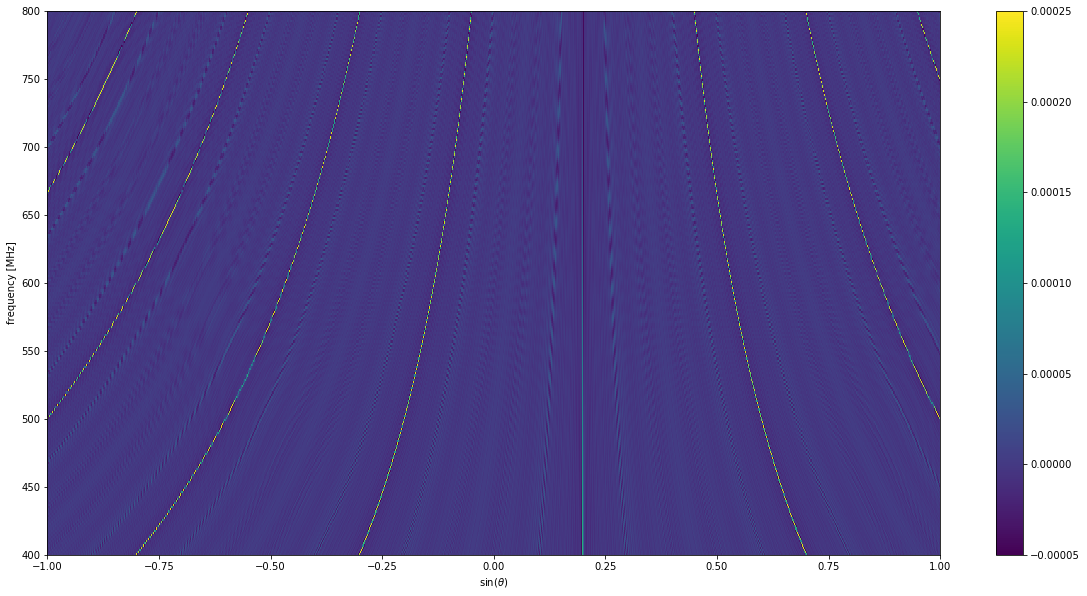

In [10]:
telescope.plot_rmap(rmap_no_error, vmax=0.00025, vmin=-0.00005)

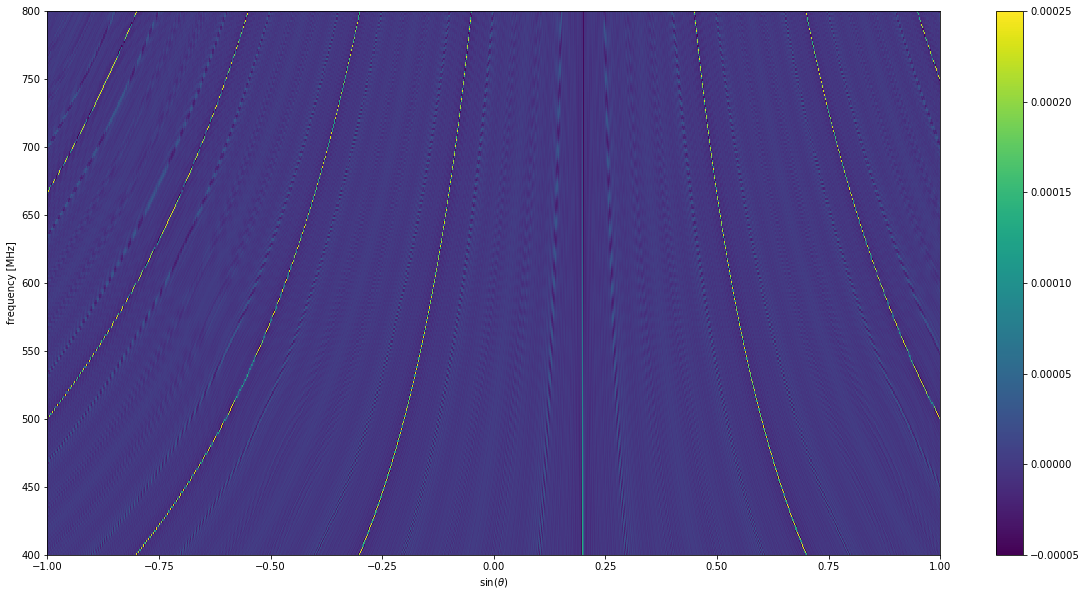

In [11]:
telescope.plot_rmap(rmap_with_error, vmax=0.00025, vmin=-0.00005)

Get the residuals.

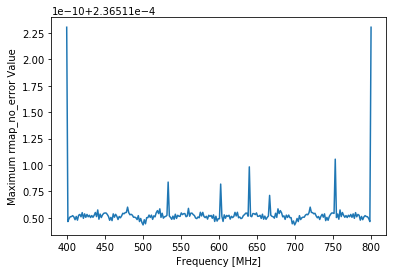

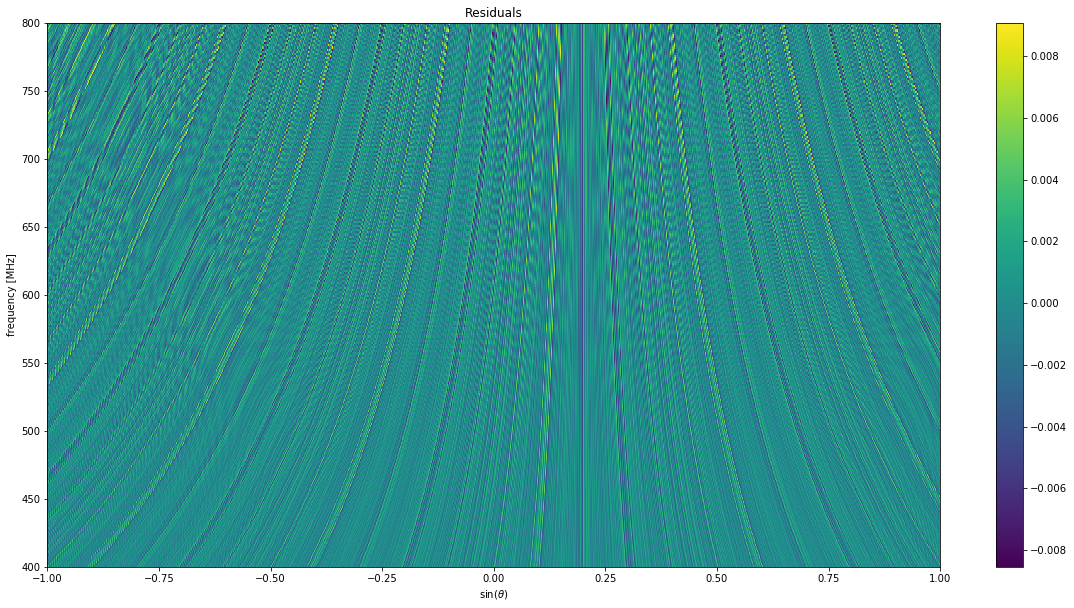

In [12]:
# Plot the residuals
# This also checks that rmap_no_error maxima are frequency independent for the most part
residuals = telescope.get_rmap_residuals(rmap_no_error, rmap_with_error, n=1)

Fundamental mode for chunk 0 is 0.009735865670439258
Fundamental mode for chunk 1 is 0.011064930450611495
Fundamental mode for chunk 2 is 0.01247847854944452
Fundamental mode for chunk 3 is 0.014031088553509664


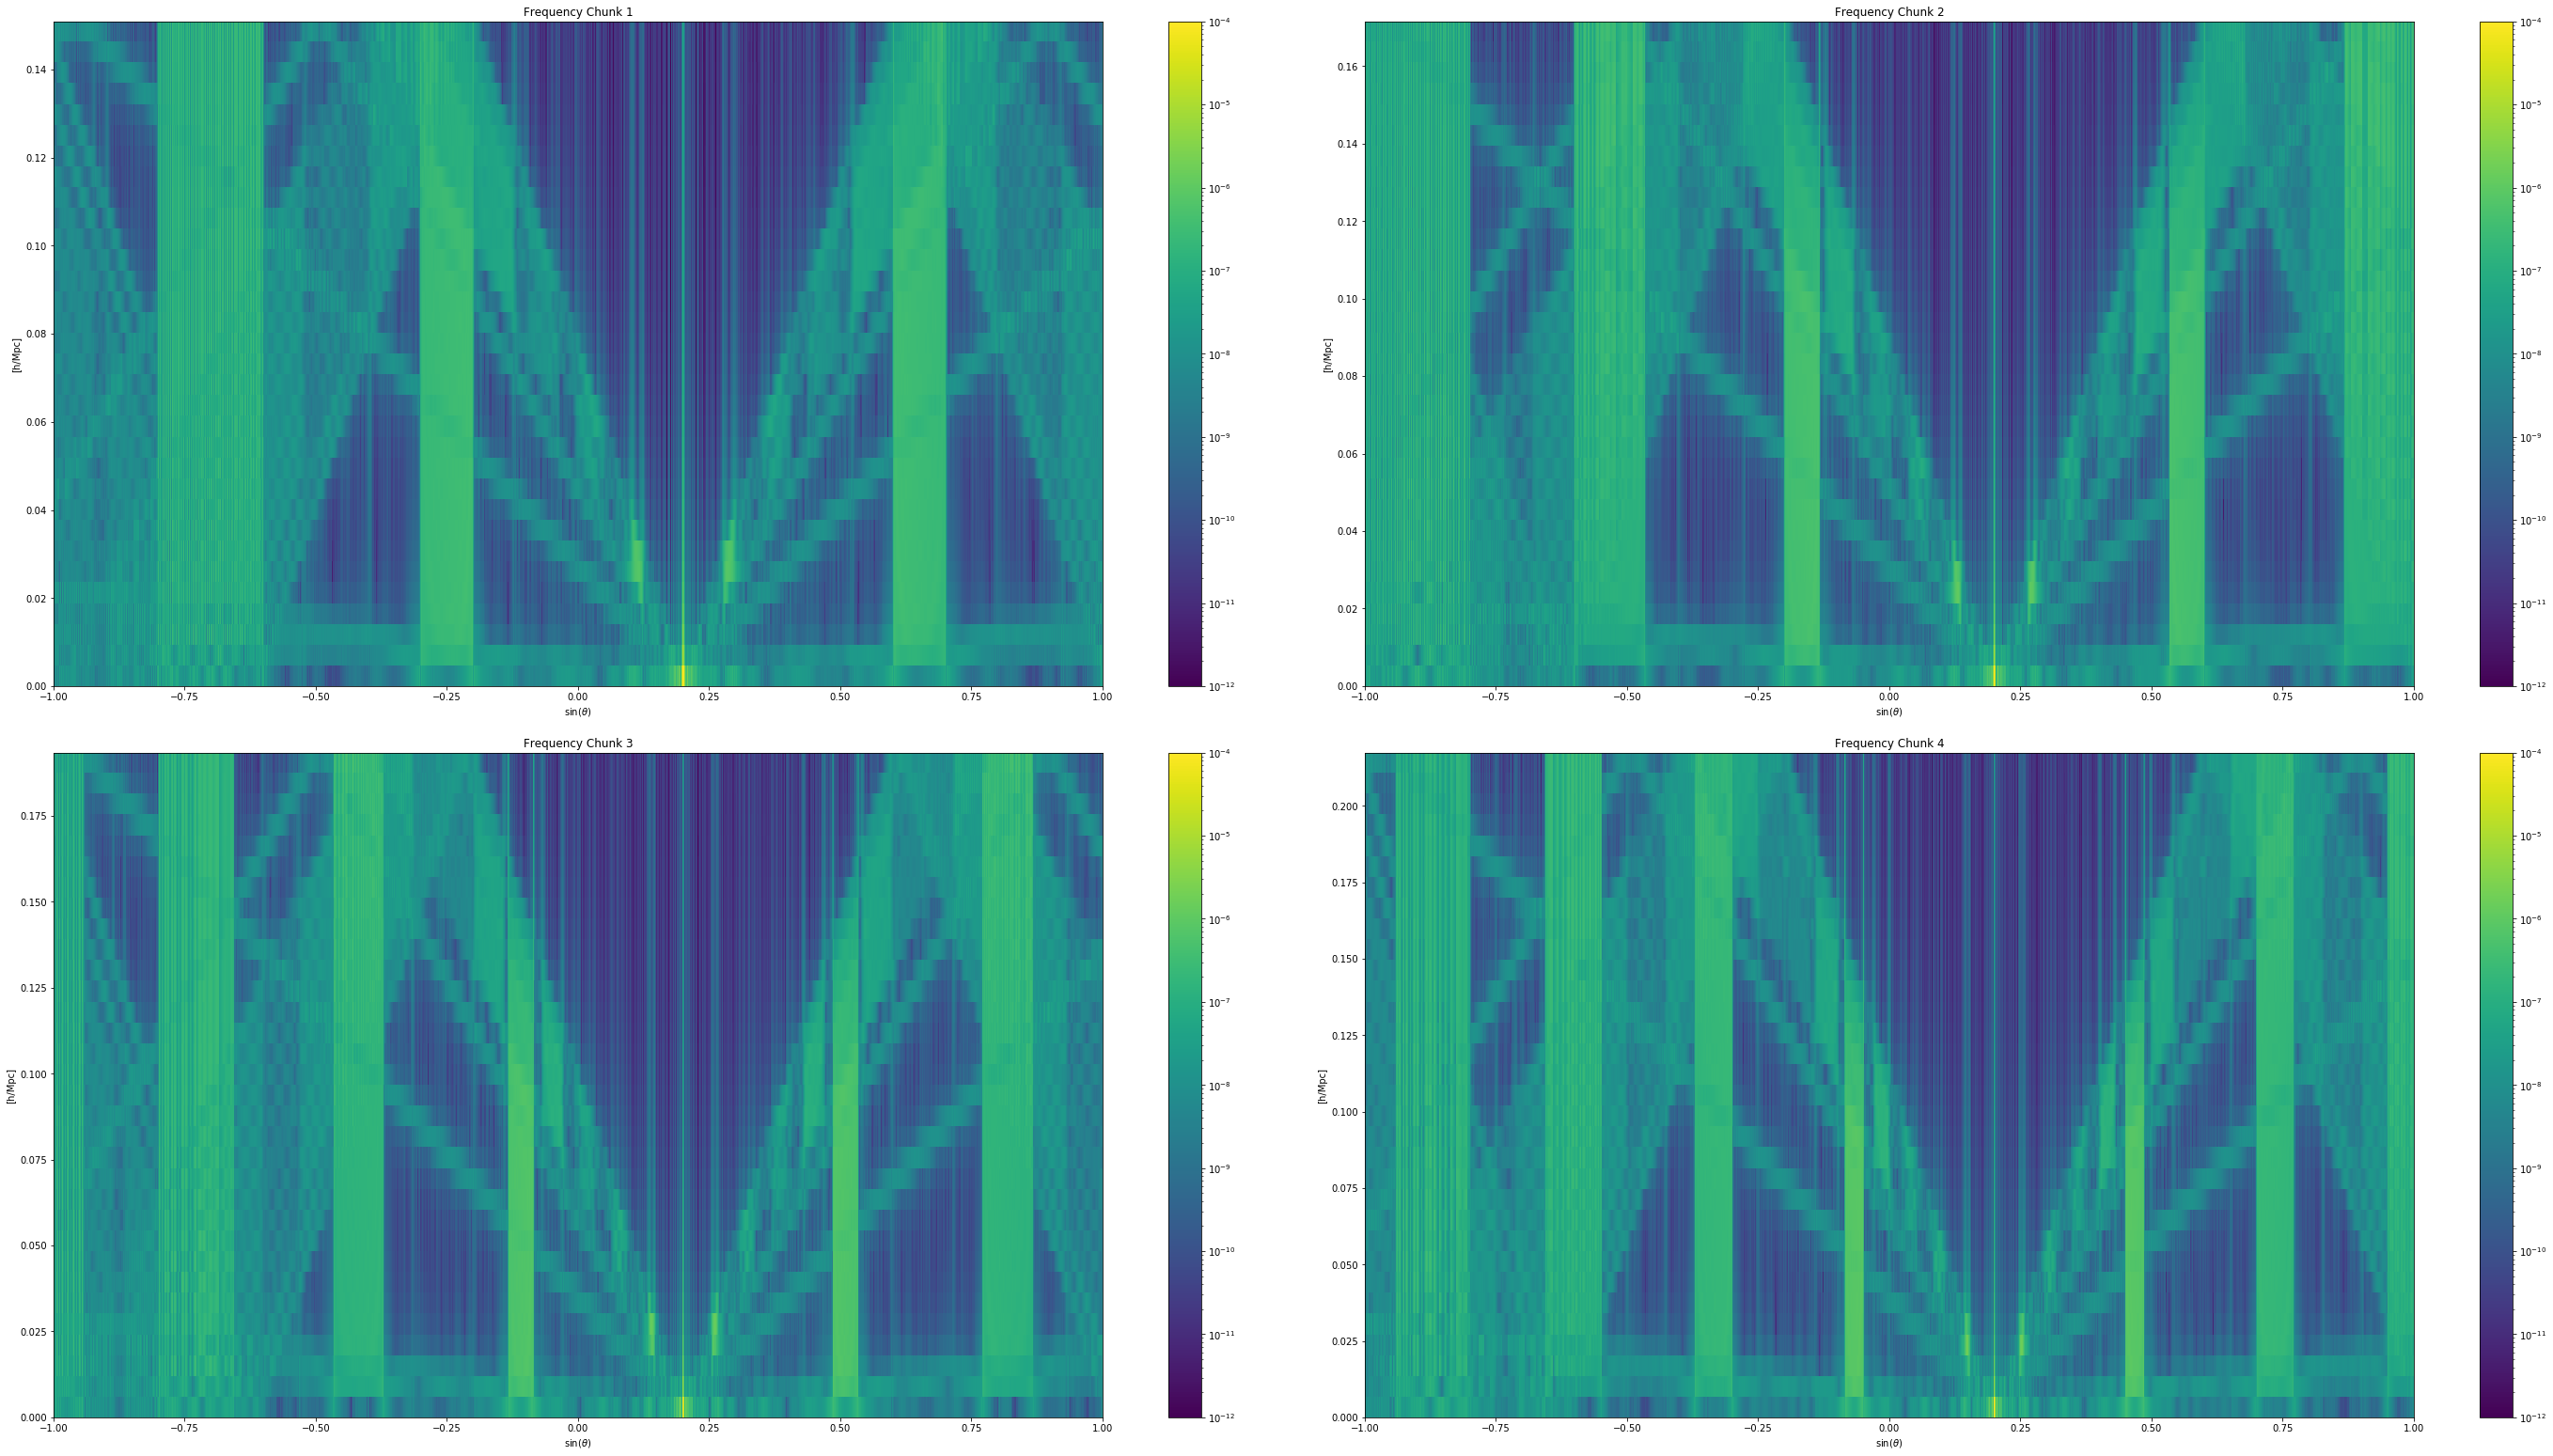

In [13]:
# Divide into 4 frequency chunks and in each chunk FT along the line of sight and square to get the power spectrum
# After getting the power spectra, bin in both x and y directions (2 frequencies per bin, 2 alphas per bin)
(ps_binned_no_error, k_modes_no_error, alpha_binned_no_error) = telescope.get_rmap_ps(rmap_no_error, Nfreqchunks=4, m_alpha=2, m_freq=2, vmin=1e-12, vmax=1e-4, log=True)

Fundamental mode for chunk 0 is 0.009735865670439258
Fundamental mode for chunk 1 is 0.011064930450611495
Fundamental mode for chunk 2 is 0.01247847854944452
Fundamental mode for chunk 3 is 0.014031088553509664


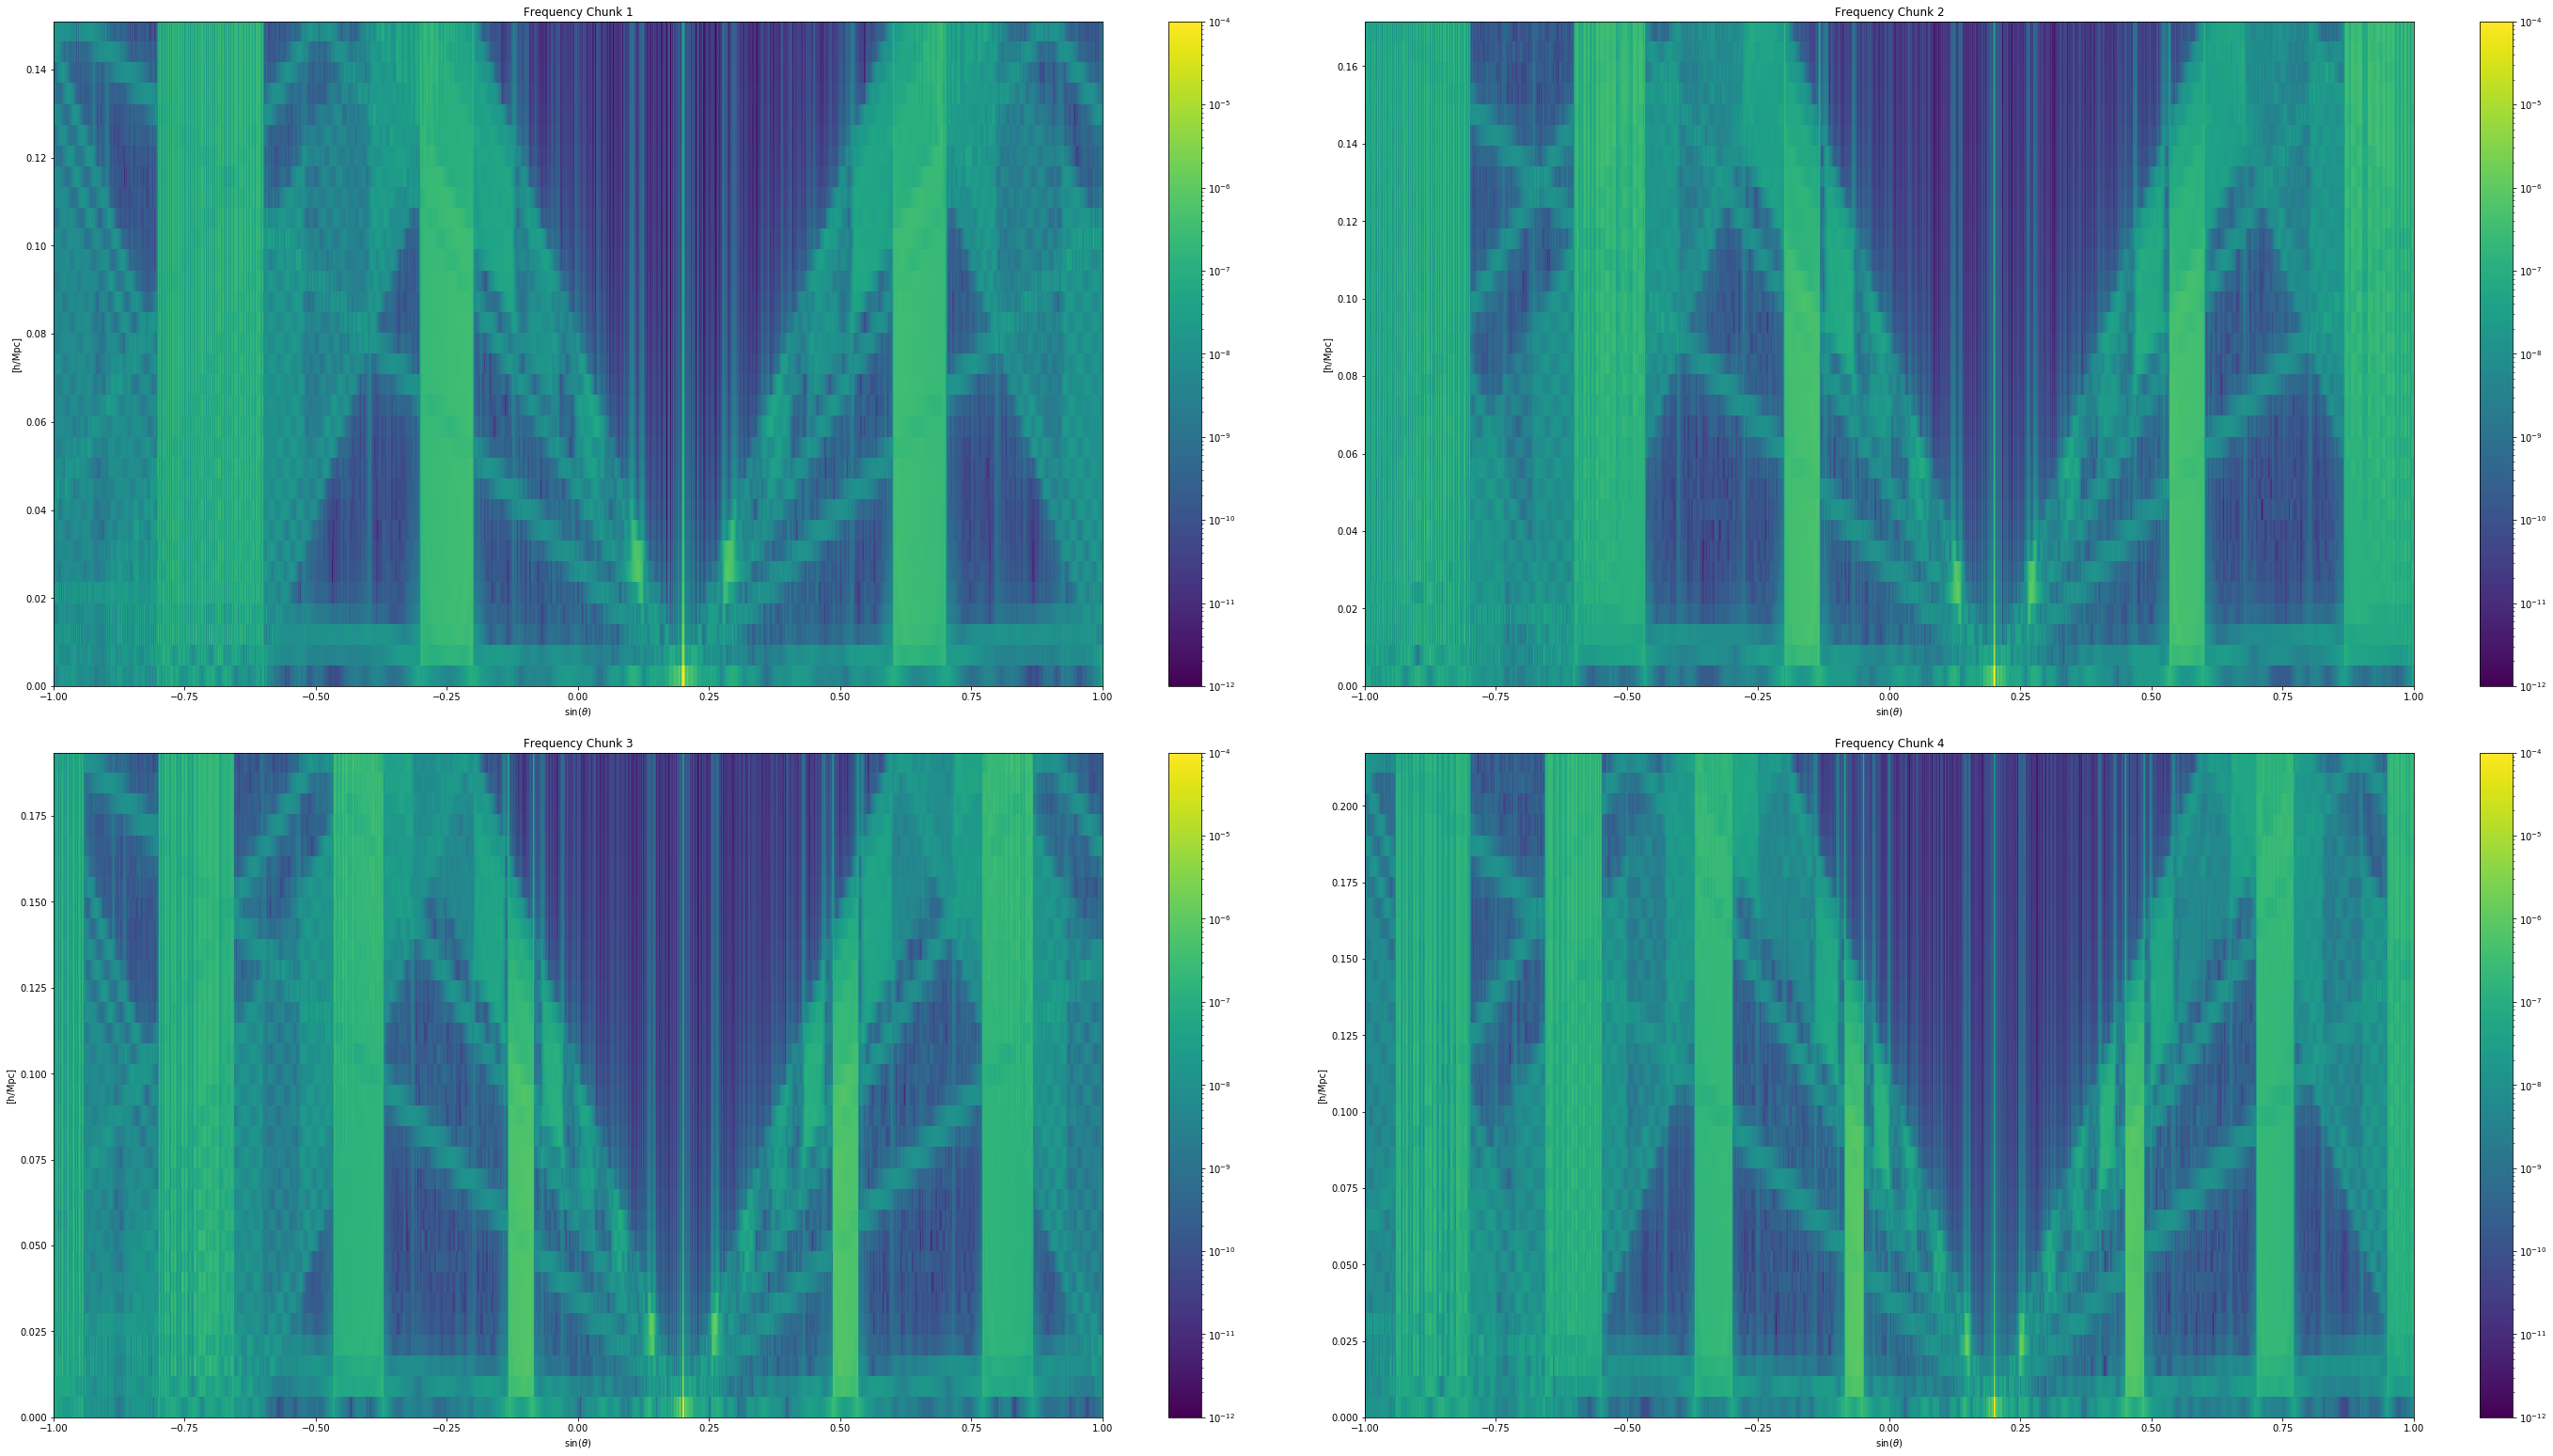

In [14]:
# Similarly for the rmap with error
(ps_binned_with_error, k_modes_with_error, alpha_binned_with_error) = telescope.get_rmap_ps(rmap_with_error, Nfreqchunks=4, m_alpha=2, m_freq=2, vmin=1e-12, vmax=1e-4, log=True)

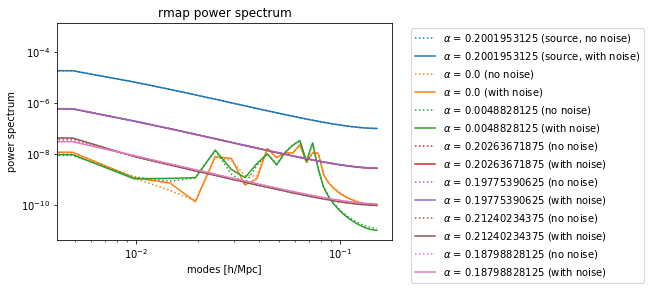

In [15]:
# Try plotting slices of the power spectra for certain alphas
# Here, the different colors are different alphas (blue is where the source is), the dotted lines are for no noise, solid lines with noise
telescope.plot_rmap_ps_slice(ps_binned_no_error, ps_binned_with_error, k_modes_no_error, alpha_binned_no_error, alpha_idx_source=[idx], chunk=0)

Redo for redundant array.

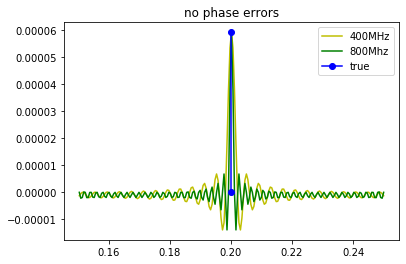

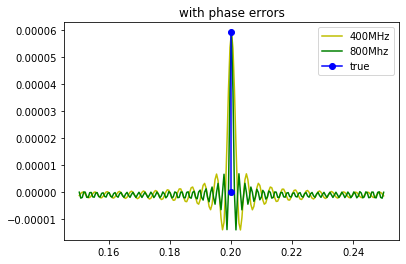

In [16]:
telescope = telescope_1d.Telescope1D(Nfreq=256, Ndishes=32, DDish=6, Npix_fft=2**12, Npad=2**8,
                                     minfreq=400, maxfreq=800, redundant=True)

uvplane = telescope.uv2uvplane(uv, indices=None)
rmap_no_error = telescope.get_obs_rmap(uvplane, time_error_sigma=0)
rmap_with_error = telescope.get_obs_rmap(uvplane, time_error_sigma=10e-12)

plt.plot(telescope.alpha[wal],rmap_no_error[0,wal[0]],'y-',label='400MHz')
plt.plot(telescope.alpha[wal],rmap_no_error[255,wal[0]],'g-',label='800Mhz')
plt.plot([al,al],[0,rmap_no_error.max()],'bo-',label='true')
plt.title('no phase errors')
plt.legend()
plt.show()

plt.plot(telescope.alpha[wal],rmap_with_error[0,wal[0]],'y-',label='400MHz')
plt.plot(telescope.alpha[wal],rmap_with_error[255,wal[0]],'g-',label='800Mhz')
plt.plot([al,al],[0,rmap_with_error.max()],'bo-',label='true')
plt.title('with phase errors')
plt.legend()
plt.show()

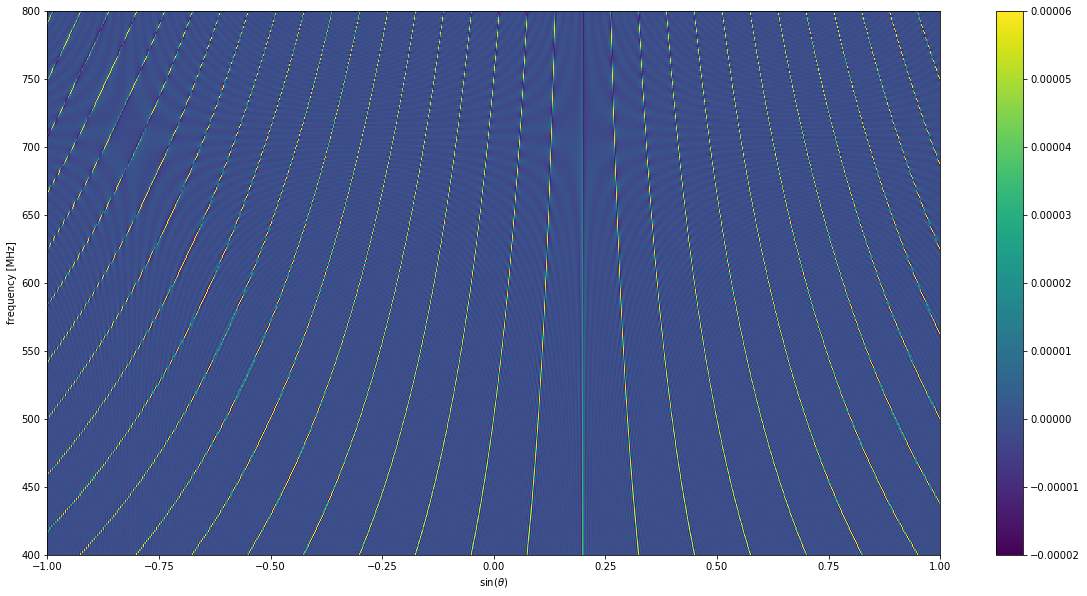

In [17]:
telescope.plot_rmap(rmap_no_error, vmax=0.00006, vmin=-0.00002)

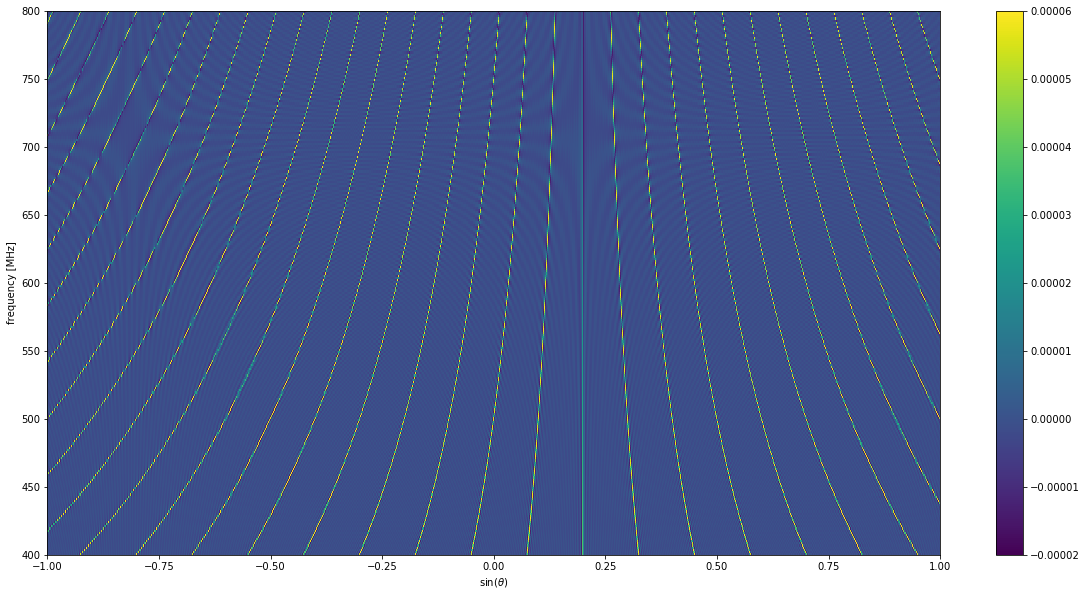

In [18]:
telescope.plot_rmap(rmap_with_error, vmax=0.00006, vmin=-0.00002)

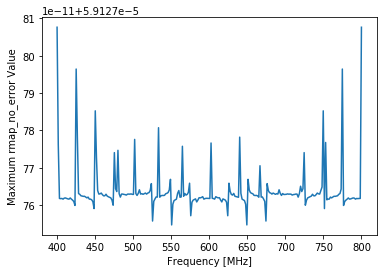

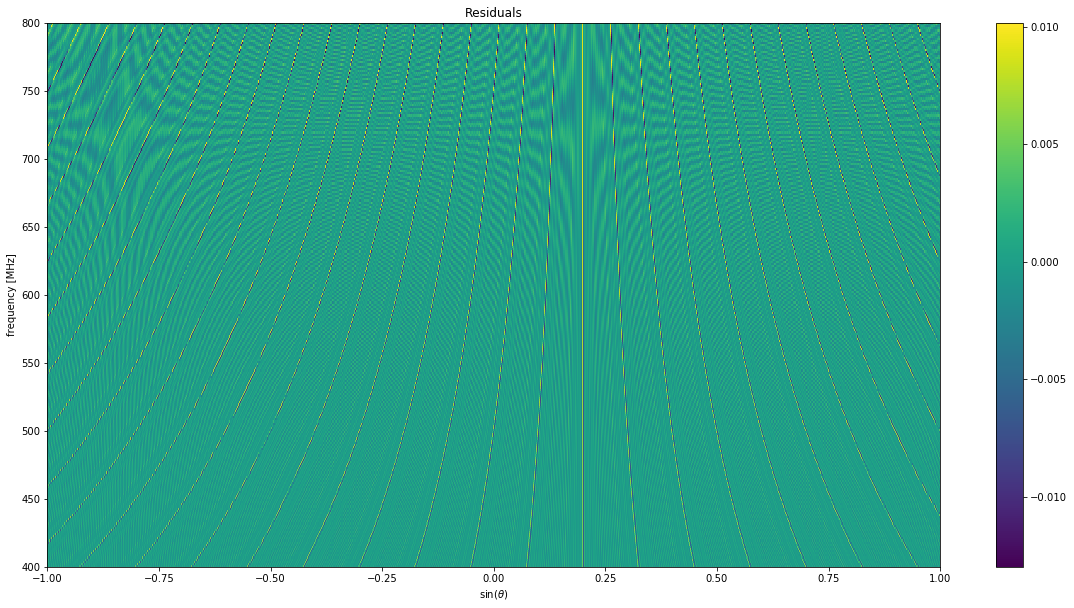

In [19]:
# Plot the residuals
# This also checks that rmap_no_error maxima are frequency independent for the most part
residuals = telescope.get_rmap_residuals(rmap_no_error, rmap_with_error, n=1)

Fundamental mode for chunk 0 is 0.009735865670439258
Fundamental mode for chunk 1 is 0.011064930450611495
Fundamental mode for chunk 2 is 0.01247847854944452
Fundamental mode for chunk 3 is 0.014031088553509664


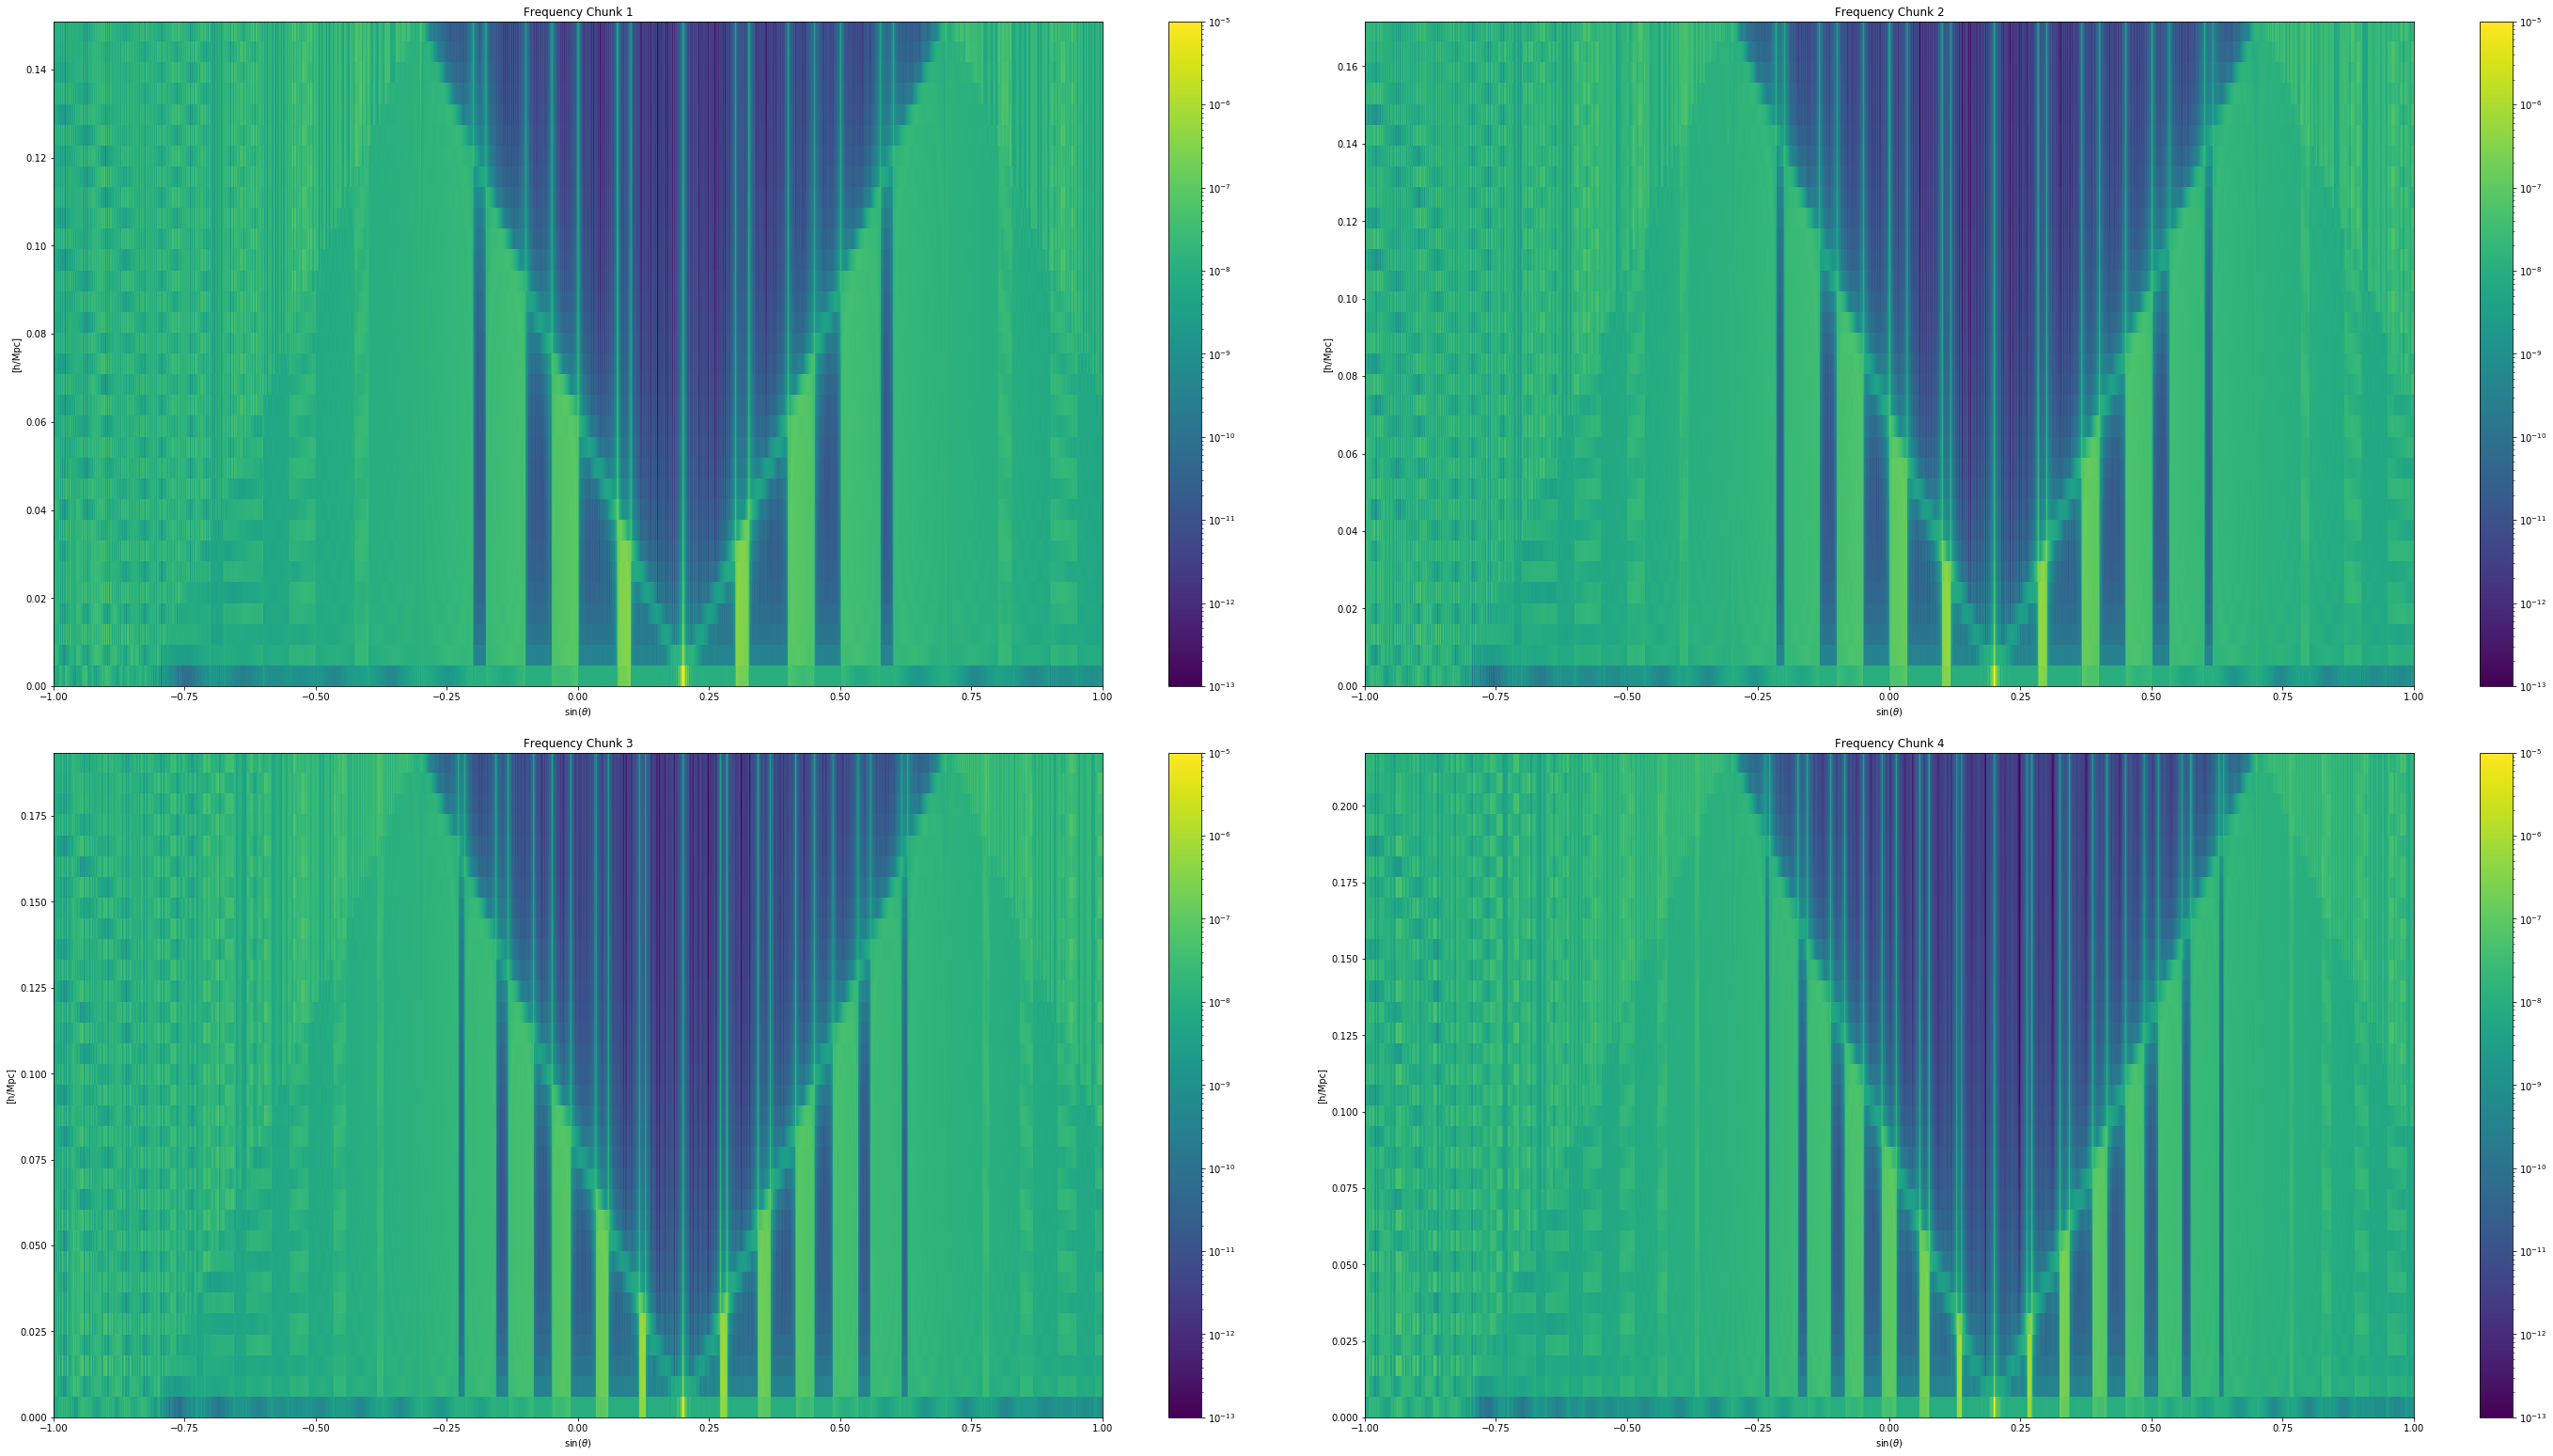

In [20]:
# Divide into 4 frequency chunks and in each chunk FT along the line of sight and square to get the power spectrum
# After getting the power spectra, bin in both x and y directions (2 frequencies per bin, 2 alphas per bin)
(ps_binned_no_error, k_modes_no_error, alpha_binned_no_error) = telescope.get_rmap_ps(rmap_no_error, Nfreqchunks=4, m_alpha=2, m_freq=2, vmin=1e-13, vmax=1e-5, log=True)

Fundamental mode for chunk 0 is 0.009735865670439258
Fundamental mode for chunk 1 is 0.011064930450611495
Fundamental mode for chunk 2 is 0.01247847854944452
Fundamental mode for chunk 3 is 0.014031088553509664


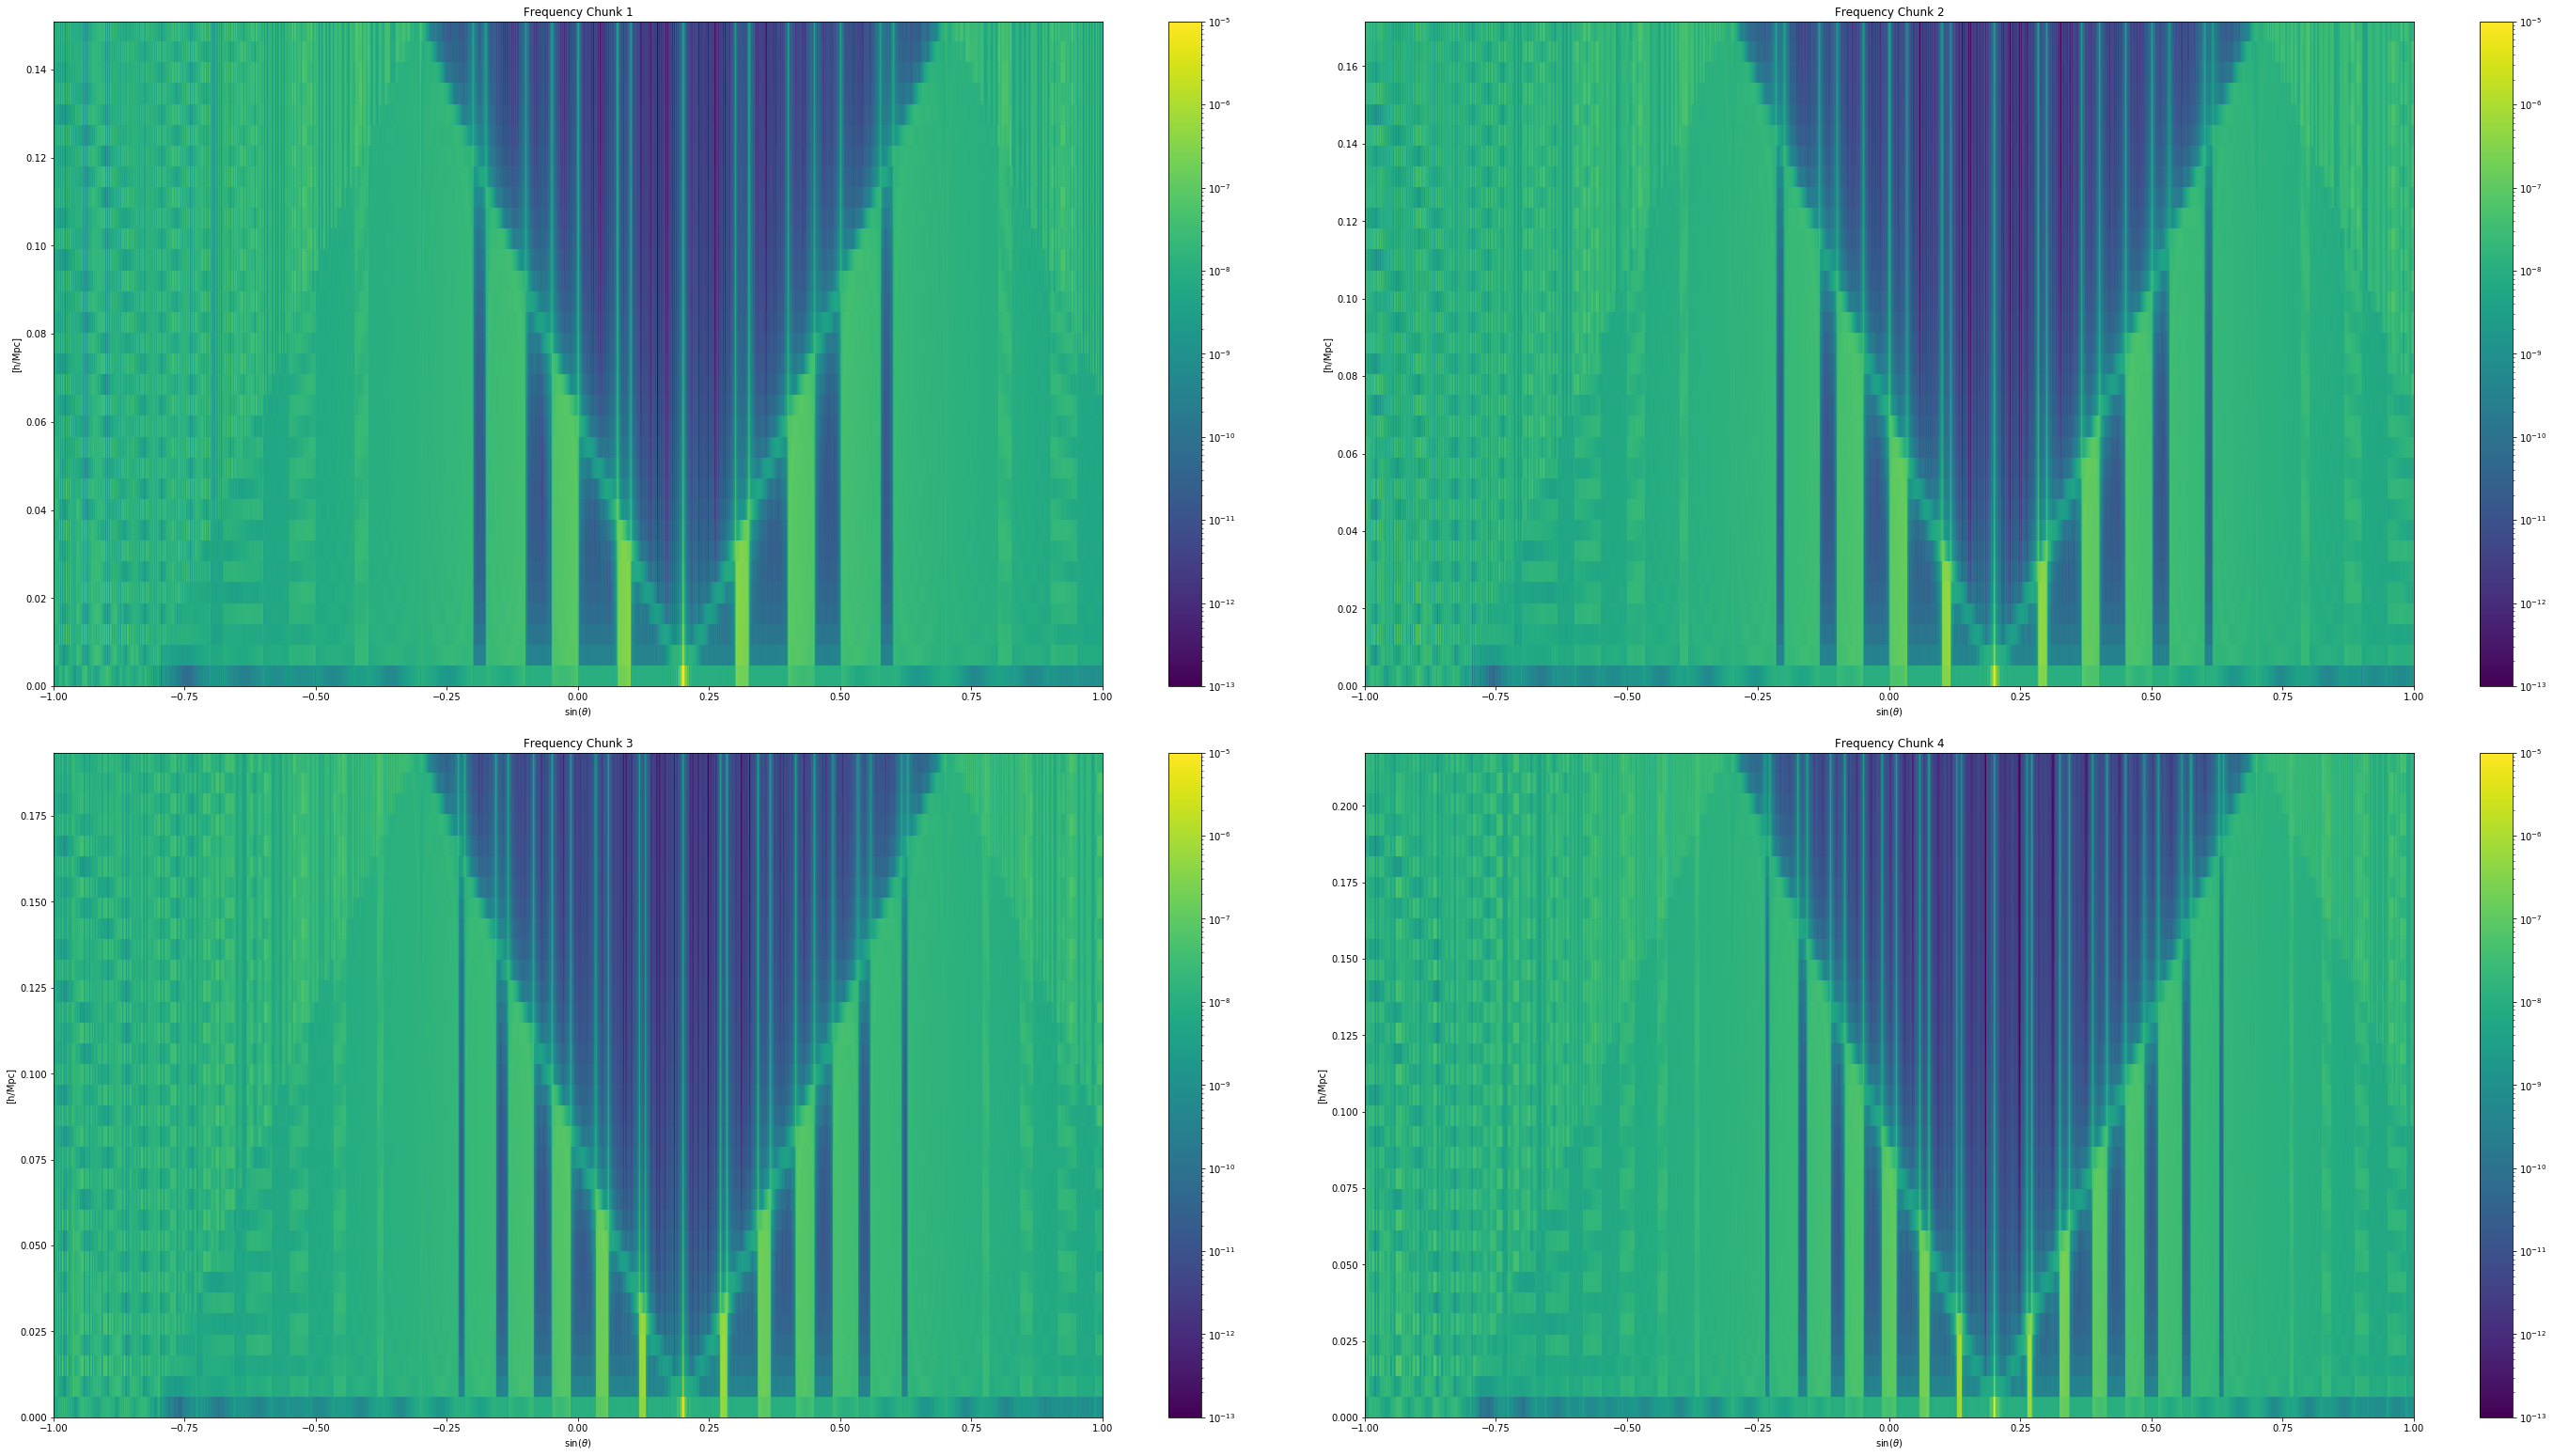

In [21]:
# Similarly for the rmap with error
(ps_binned_with_error, k_modes_with_error, alpha_binned_with_error) = telescope.get_rmap_ps(rmap_with_error, Nfreqchunks=4, m_alpha=2, m_freq=2, vmin=1e-13, vmax=1e-5, log=True)

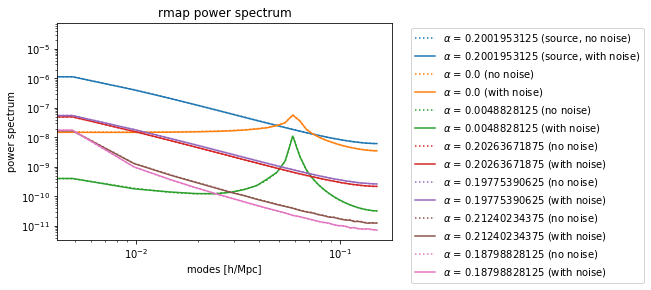

In [22]:
# Try plotting slices of the power spectra for certain alphas
# Here, the different colors are different alphas (blue is where the source is), the dotted lines are for no noise, solid lines with noise
telescope.plot_rmap_ps_slice(ps_binned_no_error, ps_binned_with_error, k_modes_no_error, alpha_binned_no_error, alpha_idx_source=[idx], chunk=0)

Back to a non-redundant array, let's see how the result would change if we instead of a single point source, model the signal as a random sky. This time we don't ignore the beam here.

In [23]:
telescope = telescope_1d.Telescope1D(Nfreq=256, Ndishes=32, DDish=6, Npix_fft=2**12, Npad=2**8,
                                     minfreq=400, maxfreq=800, redundant=False)
image = telescope.get_uniform_sky(high=2)
uvplane = telescope.beam_convolution(image)

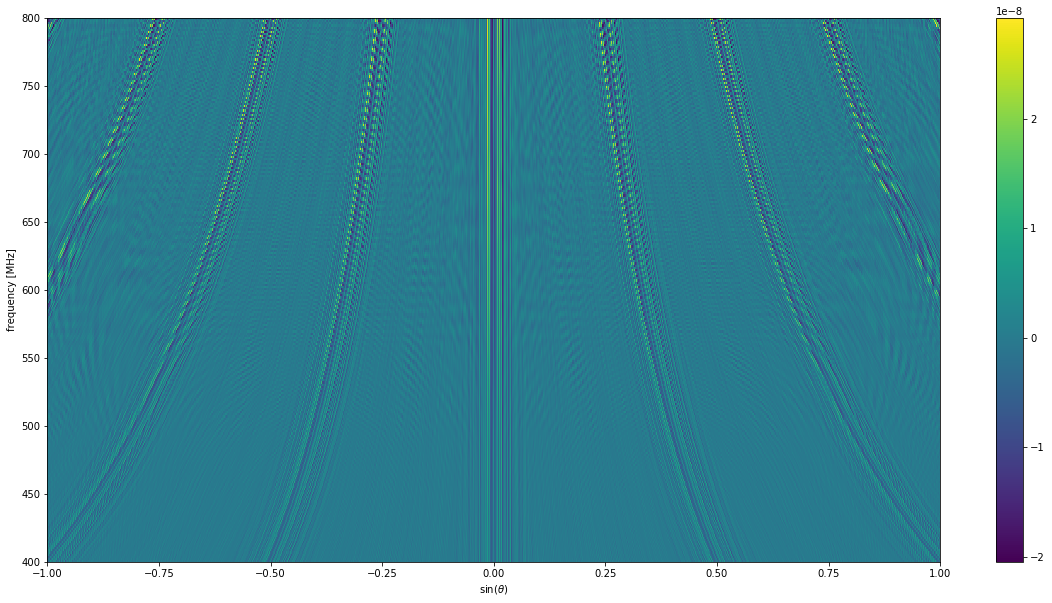

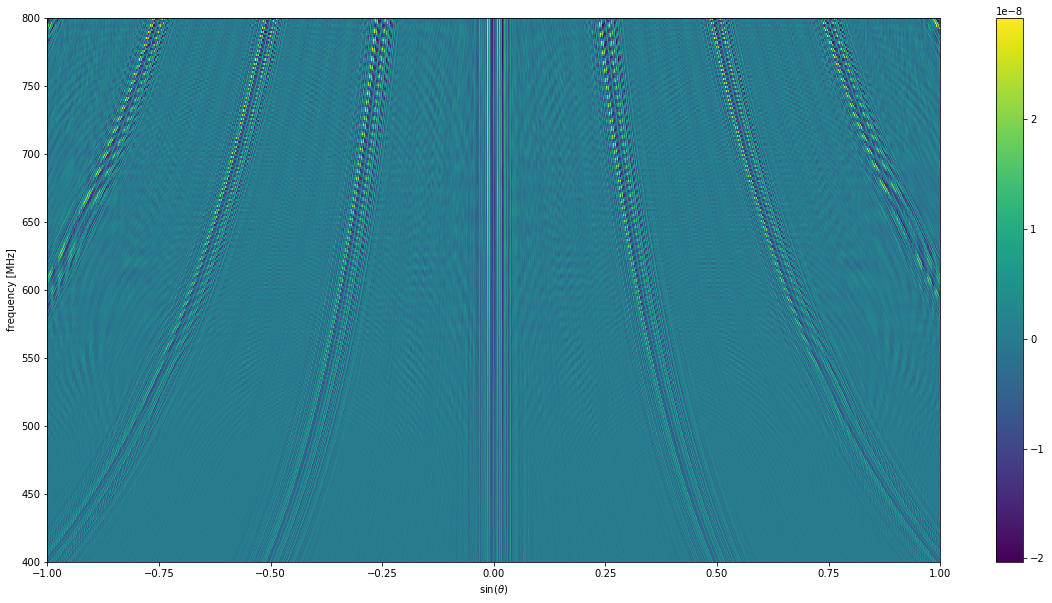

In [24]:
rmap_no_error = telescope.get_obs_rmap(uvplane, time_error_sigma=0)
rmap_with_error = telescope.get_obs_rmap(uvplane, time_error_sigma=10e-12)

telescope.plot_rmap(rmap_no_error)
telescope.plot_rmap(rmap_with_error)

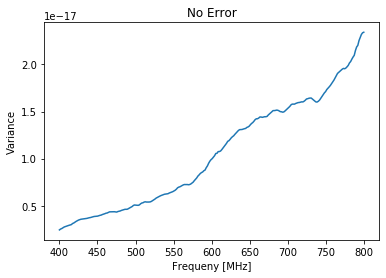

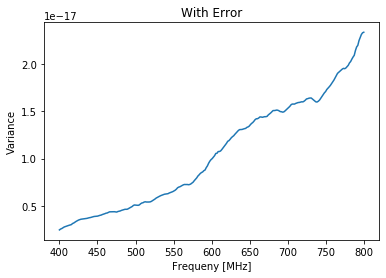

In [25]:
# Plot the variance of rmap_no_error and rmap_with_error as a function of frequency
var_no_error = np.var(rmap_no_error, axis=1)
var_with_error = np.var(rmap_with_error, axis=1)

plt.plot(telescope.freqs, var_no_error)
plt.xlabel('Frequeny [MHz]')
plt.ylabel('Variance')
plt.title('No Error')
plt.show()

plt.plot(telescope.freqs, var_with_error)
plt.xlabel('Frequeny [MHz]')
plt.ylabel('Variance')
plt.title('With Error')
plt.show()

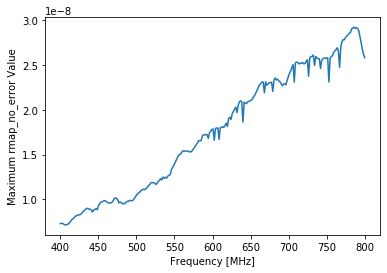

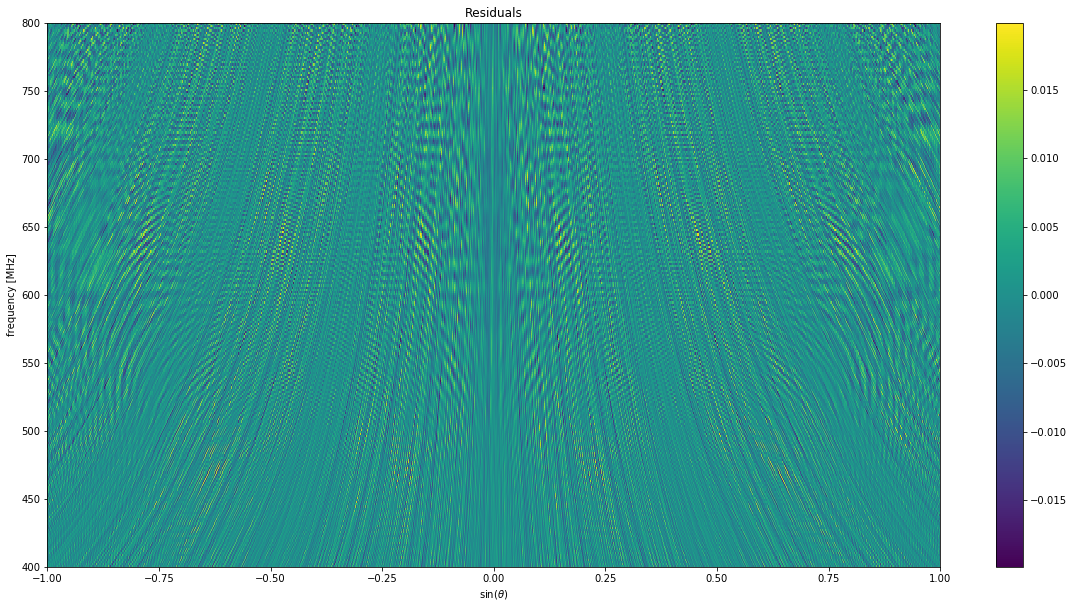

In [26]:
# Plot the residuals
# This also checks that rmap_no_error maxima are frequency independent for the most part
residuals = telescope.get_rmap_residuals(rmap_no_error, rmap_with_error, n=1)

Fundamental mode for chunk 0 is 0.009735865670439258
Fundamental mode for chunk 1 is 0.011064930450611495
Fundamental mode for chunk 2 is 0.01247847854944452
Fundamental mode for chunk 3 is 0.014031088553509664


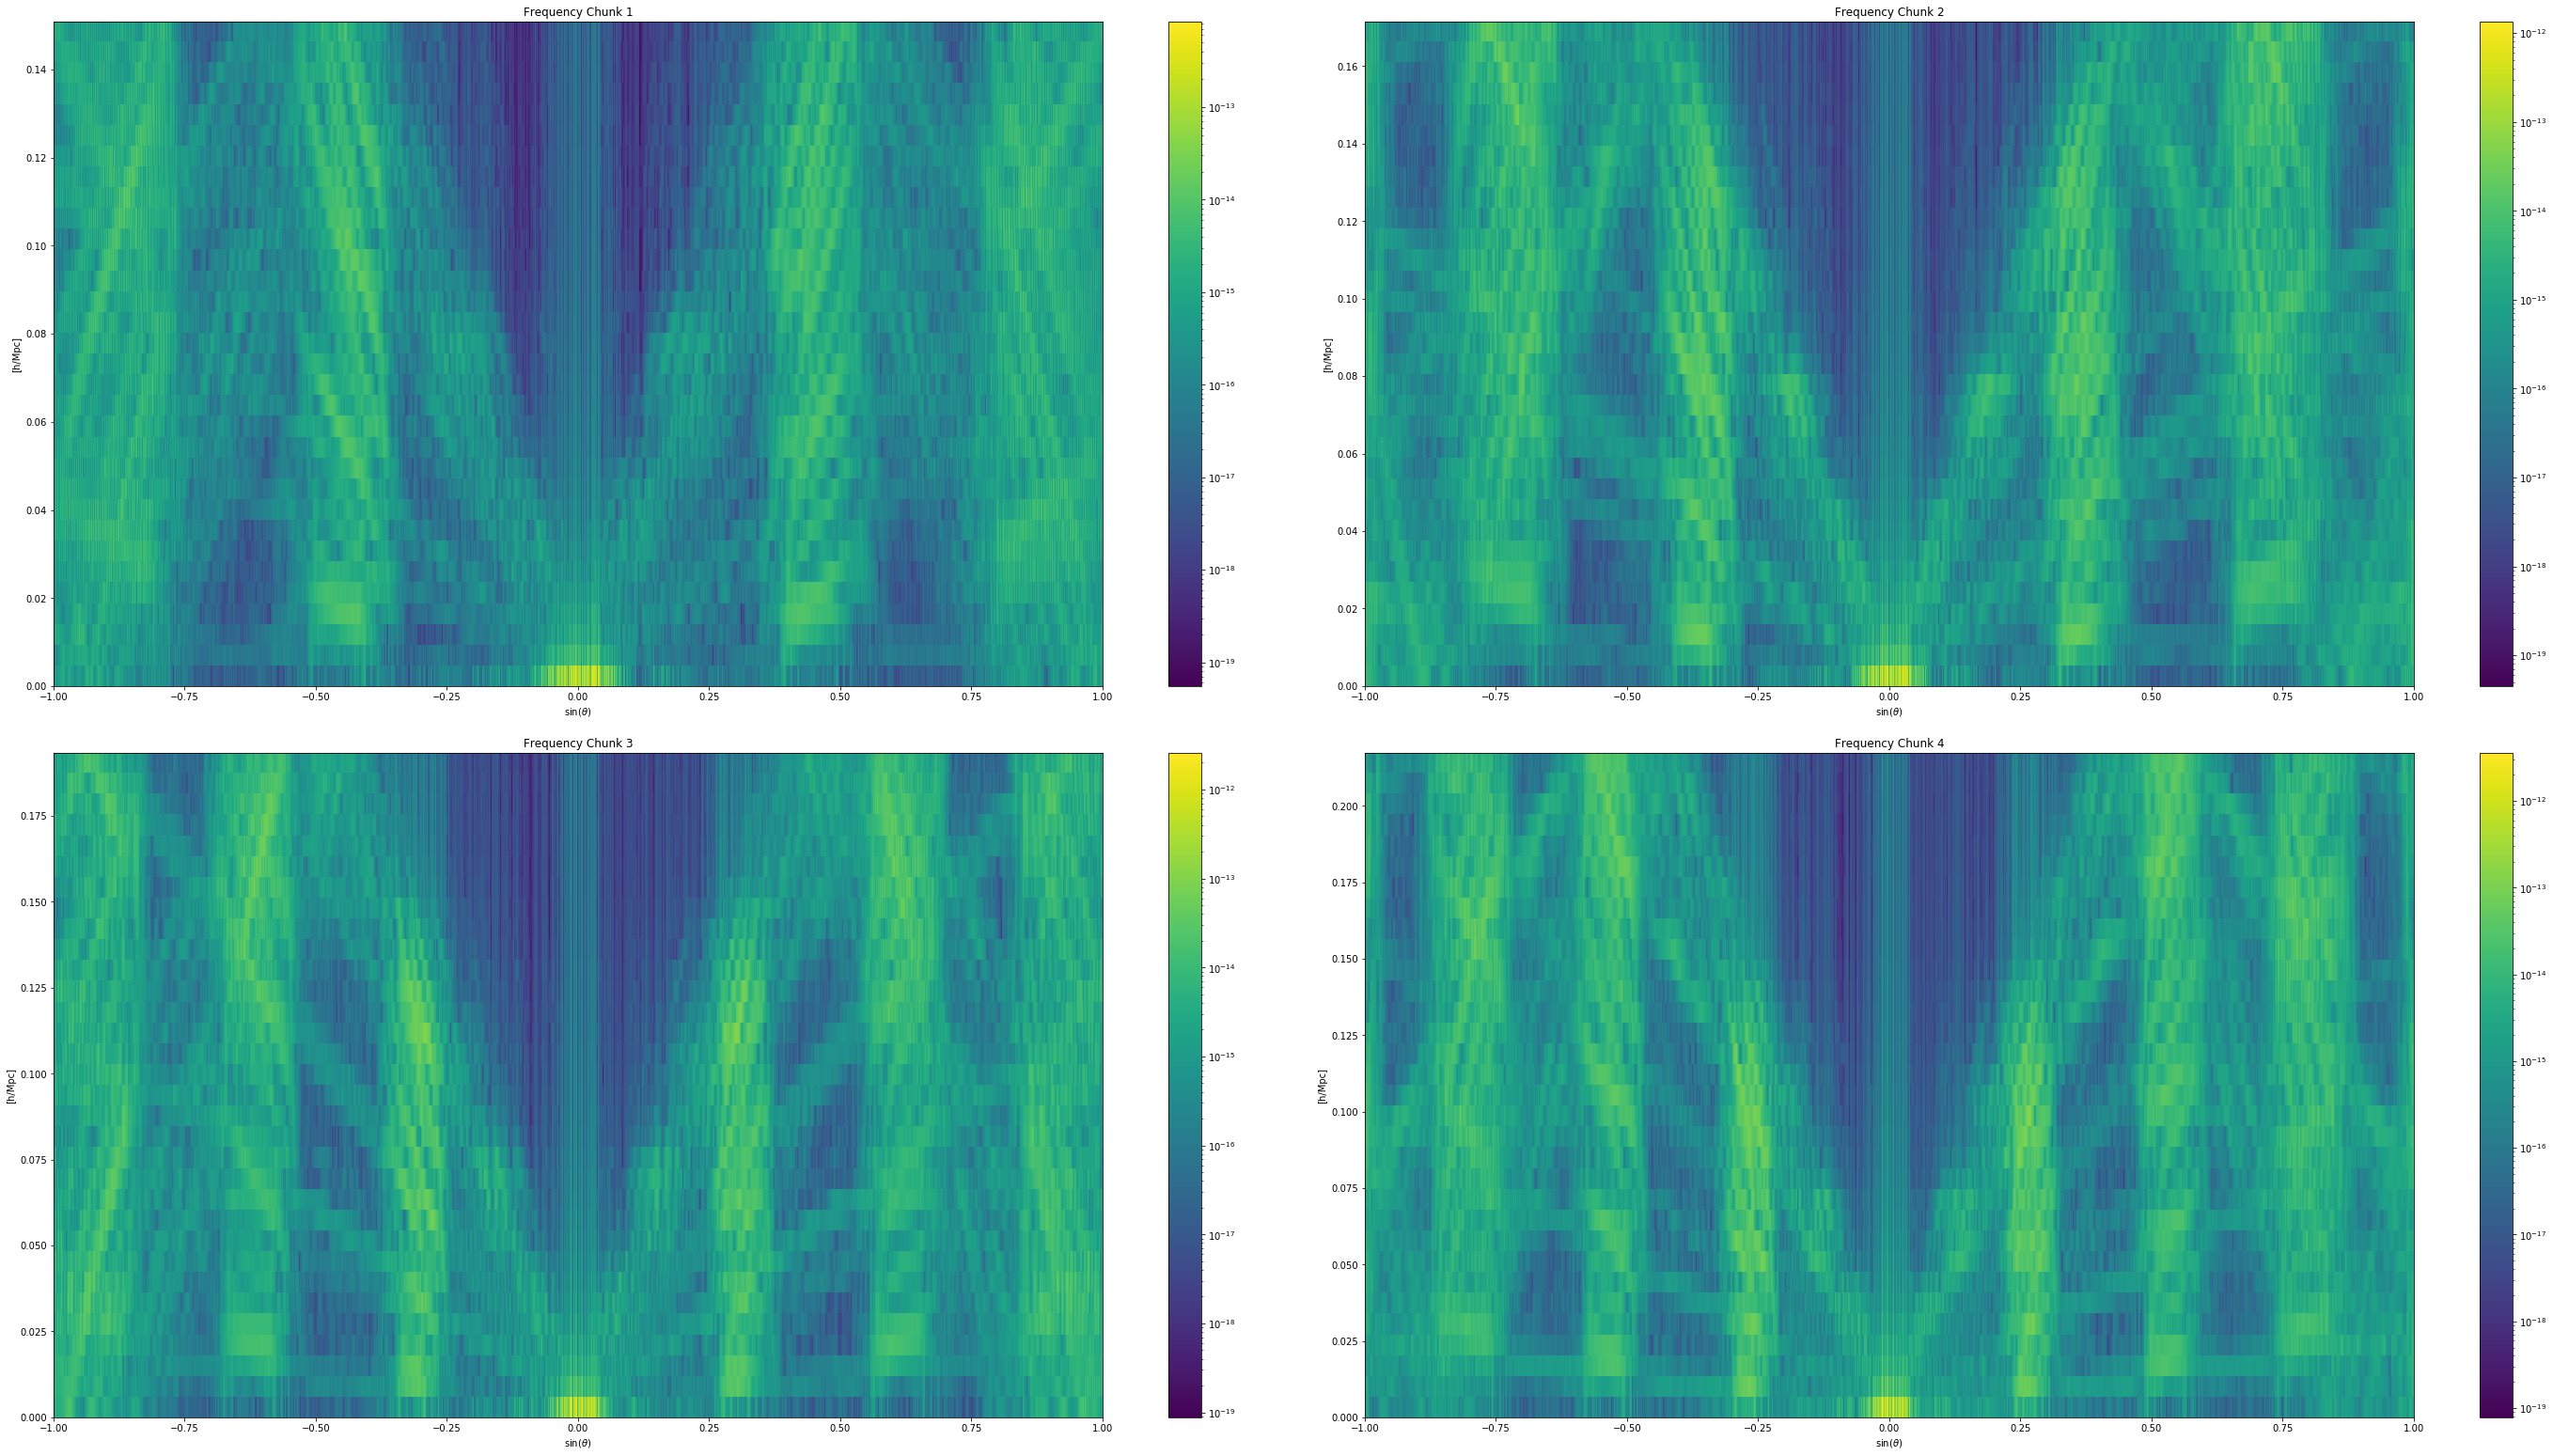

In [27]:
(ps_binned_no_error, k_modes_no_error, alpha_binned_no_error) = telescope.get_rmap_ps(rmap_no_error, Nfreqchunks=4, m_alpha=2, m_freq=2, log=True)

Fundamental mode for chunk 0 is 0.009735865670439258
Fundamental mode for chunk 1 is 0.011064930450611495
Fundamental mode for chunk 2 is 0.01247847854944452
Fundamental mode for chunk 3 is 0.014031088553509664


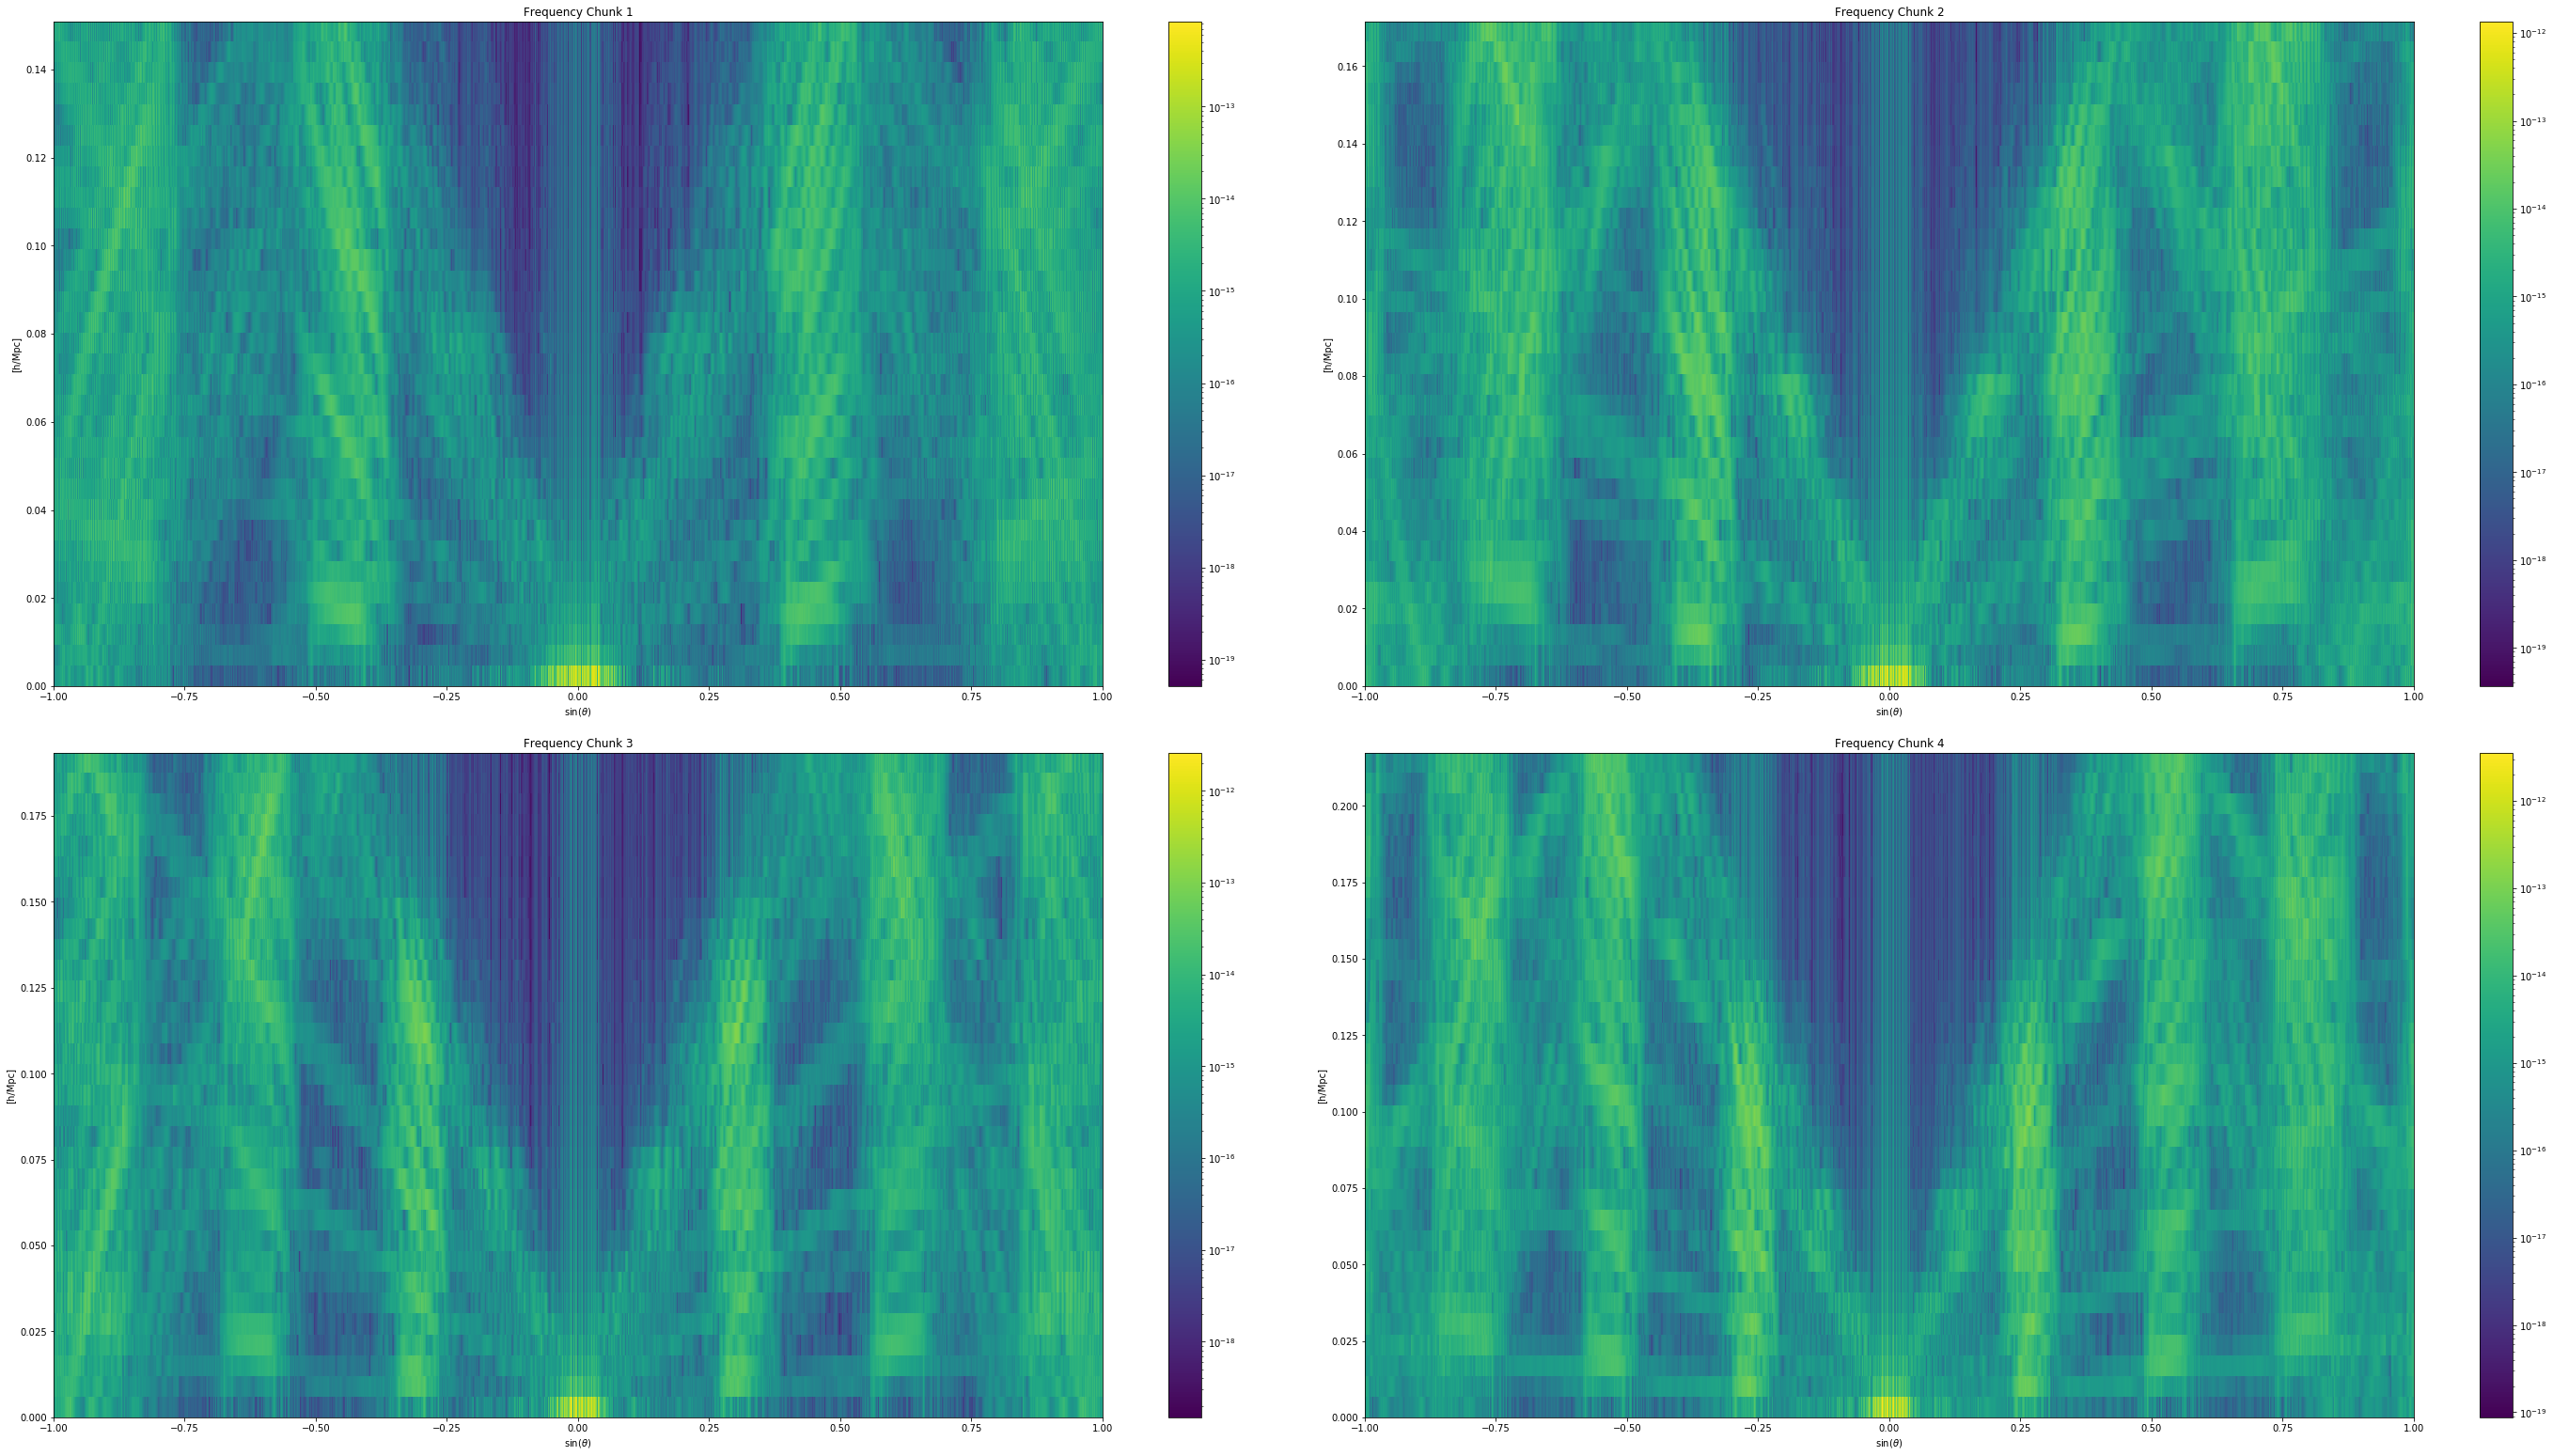

In [28]:
# Similarly for the rmap with error
(ps_binned_with_error, k_modes_with_error, alpha_binned_with_error) = telescope.get_rmap_ps(rmap_with_error, Nfreqchunks=4, m_alpha=2, m_freq=2, log=True)

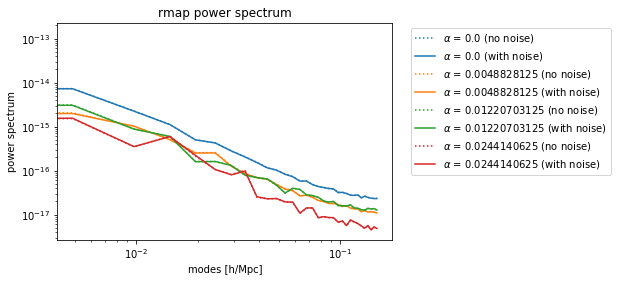

In [29]:
# Try plotting slices of the power spectra for certain alphas
# Here, the different colors are different alphas, the dotted lines are for no noise, solid lines with noise
telescope.plot_rmap_ps_slice(ps_binned_no_error, ps_binned_with_error, k_modes_no_error, alpha_binned_no_error, alpha_idx_source=[], 
                             alpha_idx_no_source=[telescope.Npix//2, telescope.Npix//2+10, telescope.Npix//2+25, telescope.Npix//2+50], chunk=0)

Now let's plot some wedge.

/usr/lib/python3/dist-packages/numpy/fft/_pocketfft.py:77: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)


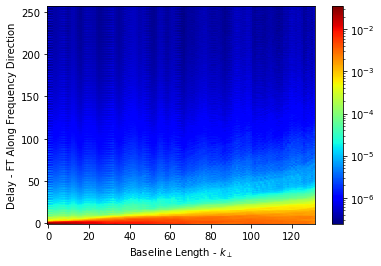

In [30]:
wedge_no_error = telescope.plot_wedge(Nreal=100, time_error_sigma=0)